# Let's start by importing all the necessary modules to work in our project.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
%matplotlib inline

#### Now we read in our credit card file and have a glance with .head() command

In [15]:
df = pd.read_excel("default of credit card clients.xls",header=1,sep='\t')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### The ID column is not important since there is no information gain from this column, so we drop the column.  
I also renamed the target column for aesthethically purposes.

In [16]:
df.rename(columns={'default payment next month':'DEFAULT'},inplace=True)
df.drop(columns=['ID'],inplace=True)

#### Accordigly to the [UCI Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) website the classification for MARRIAGE and EDUCATION do not have 0 entries. Thus I decided to remove and treat the 0 coding as missing values. Since the dataset is failry extensive and we will gonna use only a subset should be not problem in removing those entries.

In [17]:
print(df['MARRIAGE'].unique())

print(df['EDUCATION'].unique())

[1 2 3 0]
[2 1 3 5 4 6 0]


#### We check the amnount of missing values and then remove it, 68 values for a 30000 entries is not a big deal

In [18]:
print(df.shape)
print(len(df.loc[ (df['EDUCATION']==0) | (df['MARRIAGE']==0) ]))

df = df.loc[ (df['EDUCATION']!=0) & (df['MARRIAGE']!=0) ]

(30000, 24)
68


#### Let's downsample the data now since SVM can become quite computationally prohibitive on large datasets. In this part I will randomly sample 1000 entries from each of the level of default factor i.e. take 1000 samples from people that did default (default==1) and from people that did not default (deafult==0).  I will then concatenate both subsets.

In [21]:
df_no_default = df[df['DEFAULT']==0]
df_default    = df[df['DEFAULT']==1]

df_no_default_downsampled = resample(df_no_default,replace=False,n_samples=1000,random_state=42)
df_default_downsampled    = resample(df_default,replace=False,n_samples=1000,random_state=42)


df_downsample = pd.concat([df_no_default_downsampled,df_default_downsampled],ignore_index=True)

len(df_downsample)

2000

#### Now that we have our dataset ready. We can start  to train/test split procedure.

In [22]:
X = df_downsample.drop('DEFAULT',axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
1,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
2,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
3,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
4,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [23]:
y = df_downsample['DEFAULT'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: DEFAULT, dtype: int64

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

Since we want to scale the numeric features and one-hot encode the categorical ones. We can use Columntransfomer to apply different transformations separately with a subsequent concatenation of the features generated by these transformations.

Pipelines on the other hand are a great way to sequentially apply a list of transforms and a final estimator in a concise manner. Pipelines also help on [data leakage](https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/) prevention.

In [33]:
categorical_features = list(X.columns[[2,3,4,6,7,8,9,10,11]])
categorical_transformer = Pipeline(steps=[('onehot',OneHotEncoder(handle_unknown='ignore'))])

numerical_features = list(X.columns.difference([2,3,4,6,7,8,9,10,11]))
numerical_transformer = Pipeline(steps=[('scaler',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('cat',categorical_transformer,categorical_features),
    ('num',numerical_transformer,numerical_features),
])

clf_svm = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('SVC',SVC())
])

### The following diagram shows really well how the feature transfomraitons are integrated into the pipeline.

In [36]:
from sklearn import set_config
set_config(display='diagram')
clf_svm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EDUCATION', 'MARRIAGE',
                                                   'AGE', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6',
                                                   'BILL_AMT1']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'BILL_AMT1',
                                                   'BILL_AMT2', 'BILL_AMT3',
                                                   'BILL_AMT4', 'BILL_AMT5',
                                                   'BILL_AMT6', 'EDUCATION',
                                                   'LIMIT_BAL', 'MARRIAGE',
                                                   'PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6',
                                                   'SEX'])])),
                ('SVC', SVC())])

This line allows me to go back to default text display in sklearn

In [37]:
set_config(display='text')

### Now we only need to apply our pipeline to the traning set

In [49]:
clf_svm.fit(X_train,y_train);

### Great now let's check how well predicts the test set with a Confusion Matrix

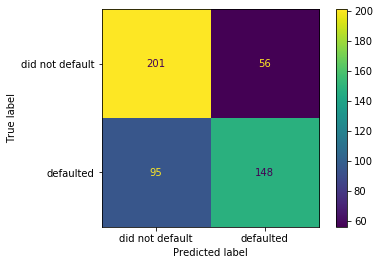

In [50]:
plot_confusion_matrix(clf_svm,X_test,y_test,display_labels=['did not default','defaulted']);

We can see that our model preditcs with approx. 78% accuracy for the people 'did not default' and  with approx. 61% accuracy for the people that 'defaulted'. The 78% comes from doing the following calculation 201/201+56 and 61% from 148/148+95.

**Can we do better ?** *Probably yes.*  

We can search over different parameter values of the Support Vector Classifier (SVC) model in order to find the best parameters for our case. We start by creating a dictionary of lists with different values for the different SVC parameters called param_grid.

Briefly C controls the bias-variance tarde-off of the SVC, when C is large then the margin is wide, many observations are involved into identifying the hyperplane and thus the variance is low while bias is high. On the other hand when C is small the margin is narrow and just a few support vectors will determine the margins of the hyperplane thus reducing bias but potentially increasing variance.

Gamma is the kernel coeffecient of the Gaussian radial basis function(rbf) and essentially controls. Small gamma will give you low bias and high variance while a large gamma will give you higher bias and low variance.

The best way to find the right hyperparameters is to use a gridsearch with cross validation as follows:

In [41]:
param_grid = {'SVC__C':[0.1,1,10,100,1000],
             'SVC__gamma':['auto','scale',1,0.1,0.01,0.001,0.0001],
             'SVC__kernel':['rbf']
             }

grid_search = GridSearchCV(clf_svm,param_grid,cv=10,verbose=3,n_jobs=-1)

Once we define the grid_search object we can apply to the whole dataset (X,y) since we are performing Stratified K-Folds cross validation. Recall that K-Folds CV involves splitting a dataset into k non-overlapping groups of rows. The model is then trained on all but one group to form a training dataset and then evaluated on the held-out fold. This process is repeated so that each fold is given a chance to be used as the holdout test set. Finally, the average performance across all evaluations is reported.

GridSearchCV uses Stratified K-Folds cross validation when the estimator is a classifier (SVC) which is our case. Briefly Stratified K-Folds means that the folds are made by preserving the percentage of samples for each class.

In [43]:
grid_search.fit(X,y);

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   15.5s finished


In [44]:
grid_search.best_params_

{'SVC__C': 100, 'SVC__gamma': 0.001, 'SVC__kernel': 'rbf'}

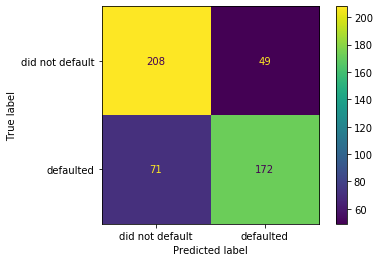

In [51]:
plot_confusion_matrix(grid_search,X_test,y_test,display_labels=['did not default','defaulted']);

We can see that our model now preditcs with approx. 81% accuracy for the people that 'did not default' and  with approx. 71% accuracy for the people that 'defaulted'. The 78% comes from doing the following calculation 208/208+49 and 71% from 172/172+71. We have approx. 10% improvement using cross validation and parameter tuning for the defaulted class, this is a huge improvement compared to the former approach.